100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:09<00:00, 10.20it/s]


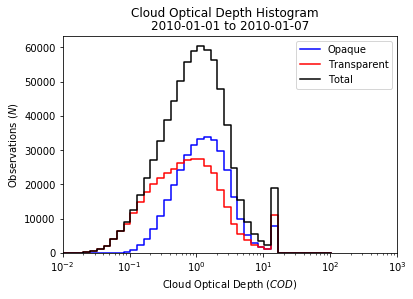

In [2]:
%matplotlib inline

# Third party imports.
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Local application imports.
import configuration
import file_loader
from file_finder import get_filenames

# Constant definitions.
DIRECTORIES = configuration.get_local_directories()

if __name__ == "__main__":
    
    # Defines the datasets to extract from each respective file.
    #
    # NOTE: Cloud layer product "Number_Layers_Found" flag only reports the
    #       number of cloud layers detected, and vice versa for aerosol layers.
    datasets = {
        "collocation_data" : [
            "Collocation_Flag",
            "CALIPSO_Lat1km",
            "CALIPSO_Lon1km",
            "MYD06_Cloud_Optical_Thickness",
        ],
        
        "collocation_indices" : [
        ],
        
        "CALIPSO_01km_data" : [
        ],
        
        "CALIPSO_05km_data" : [
            "Opacity_Flag",
            "Day_Night_Flag",
            "Feature_Classification_Flags",
            "Profile_UTC_Time",
            "Solar_Zenith_Angle",
            "Number_Layers_Found",
        ]
    }
    
    # Initializes the dataset generator.
    filenames = get_filenames(DIRECTORIES)
    datasets  = file_loader._preprocess_data(filenames, datasets)
    
    # Defines logscale bin edges and centers.
    bin_edges   = np.logspace(start = -2, stop = 3, num = 51, base = 10)
    bin_centers = np.diff(bin_edges) / 2
    
    # Sets up empty logscale histograms to add to.
    opaque_histogram      = np.histogram([], bins = bin_edges)[0]
    transparent_histogram = np.histogram([], bins = bin_edges)[0]
    
    # Iterates through datasets.
    for dataset in tqdm(datasets, total = filenames.index.size):
        
        # Aliases arrays from the dataset for brevity.
        vfm     = dataset["Feature_Classification_Flags"]
        opacity = dataset["Opacity_Flag"]
        cod     = dataset["MYD06_Cloud_Optical_Thickness"]
        
        # Masks water clouds.
        water_clouds = ((vfm.T[0] == 2) & (vfm.T[2] == 2)).T
        
        # Masks columns with no aerosols.
        no_aerosols = np.all(~(vfm.T[0] == 3).T, axis = -1)
        
        # Masks single-layer water clouds.
        single_layer_water_clouds = np.sum(water_clouds, axis = -1) == 1
        single_layer_water_clouds = single_layer_water_clouds & no_aerosols
        
        # Projects the 1D cloud mask to mask 2D opacity.
        cloud_mask = single_layer_water_clouds
        cloud_mask = np.repeat(cloud_mask, opacity.shape[-1])
        cloud_mask = cloud_mask.reshape(opacity.shape)
        
        # Identifies single-layer opaque and transparent clouds.
        single_layer_opacity = cloud_mask * opacity
        
        # Masks 1km and 5km single-layer opaque and transparent clouds.
        opacity_mask_5km = np.nansum(single_layer_opacity, axis = -1) == 1
        opacity_mask_1km = np.repeat(opacity_mask_5km, 5)
        
        # Masks NaN cloud optical depth.
        cod_nan_mask = ~np.isnan(cod)
        
        # Masks non-NaN opaque and transparent single-layer clouds.
        opacity_nan_mask      =  opacity_mask_1km & cod_nan_mask
        transparency_nan_mask = ~opacity_mask_1km & cod_nan_mask
        
        # Separates transparent and opaque cloud optical depth measurements.
        opaque_cod      = cod[opacity_nan_mask]
        transparent_cod = cod[transparency_nan_mask]
        
        # Adds cloud optical depth results to the histogram.
        opaque_histogram      += np.histogram(opaque_cod,      bin_edges)[0]
        transparent_histogram += np.histogram(transparent_cod, bin_edges)[0]
    
    # Sums the transparent and opaque histogram as the observation count.
    total_histogram = transparent_histogram + opaque_histogram
    
    # Normalizes each histogram with respect to the total area.
    opaque_pdf      = opaque_histogram      / total_histogram.sum()
    transparent_pdf = transparent_histogram / total_histogram.sum()
    total_pdf       = total_histogram       / total_histogram.sum()
    
    # Plots the histogram.
    plt.figure()
    
    plt.suptitle("Cloud Optical Depth Histogram")
    plt.title("2010-01-01 to 2010-01-07")
    
    plt.step(bin_centers,
             opaque_histogram,
             c = "b",
             label = "Opaque")
    
    plt.step(bin_centers,
             transparent_histogram,
             c = "r",
             label = "Transparent")
    
    plt.step(bin_centers,
             total_histogram,
             c = "k",
             label = "Total")
    
    plt.xscale("log")
    plt.xlim(bin_edges.min(), bin_edges.max())
    plt.ylim(bottom = 0)
    plt.xlabel(r"Cloud Optical Depth ($COD$)")
    plt.ylabel(r"Observations ($N$)")
    plt.legend()
    
    plt.show()
